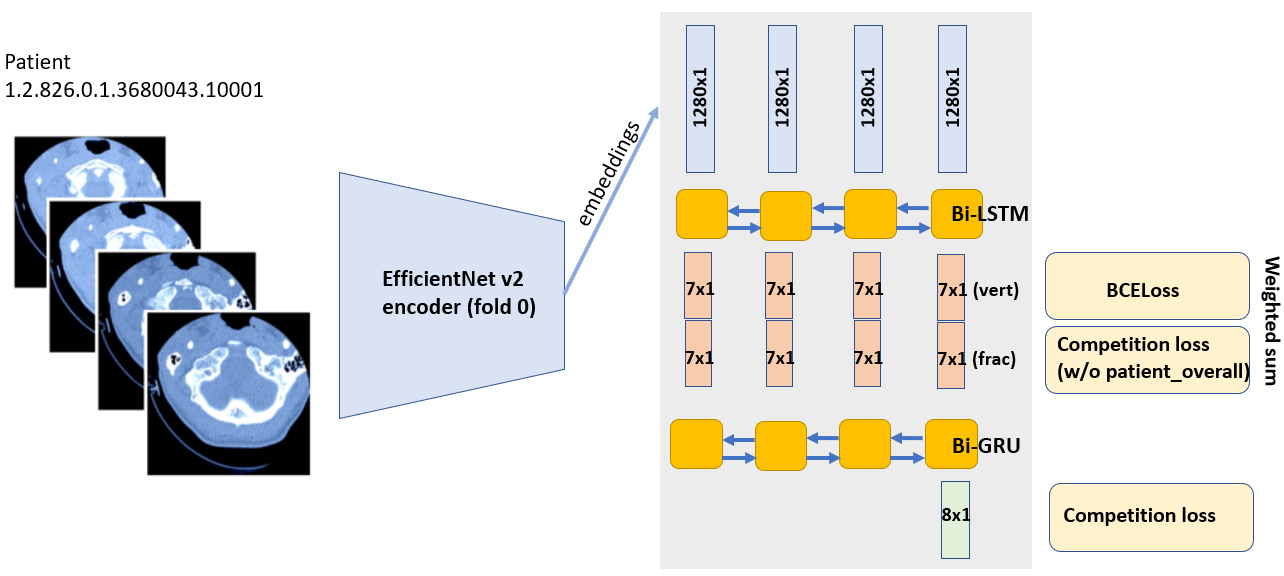

**Overview** of the modelling approach:
1. For each patient, extract 1280x1 embeddings for all slices from [[train] PyTorch-EffNetV2 baseline CV:0.49](https://www.kaggle.com/code/vslaykovsky/train-pytorch-effnetv2-baseline-cv-0-49) notebook by [
Vladimir Slaykovskiy](https://www.kaggle.com/vslaykovsky). Thus, each patient will have a sequence of 1280-dimensional vectors, i.e. a tensor of shape (num_slices, 1280). The notebook for extracting the embeddings can be found [here](https://www.kaggle.com/code/leventelippenszky/extract-effnetv2-embeddings). I used the fold 0 Effnetv2 model, so I kept folds <1,2,3,4> as the trainig folds and fold 0 as the validation fold in this notebook.
2. An LSTM was trained to predict which vertebraes are present and which ones are fractured for all slices of a patient, similarly to [[train] PyTorch-EffNetV2 baseline CV:0.49](https://www.kaggle.com/code/vslaykovsky/train-pytorch-effnetv2-baseline-cv-0-49). A sequential model can have the additional capability to capture information from other slices of the patient, instead of simply taking into account a single slice. BCELoss was used for the vertebrae detection head and the competition loss for fracture detection (without patient_overall). The final loss was determined as the weighted sum of the two losses. 
3. After 2., we have 7+7 predictions for all slices of a patient, we need to aggregate them somehow to arrive at a 8-dimensional prediction vector for a patient. We can view this as we have a sequence of 14-dim vectors for each patient, i.e. a tensor of shape (num_slices, 14). This setup is similar to sentiment analysis, where we need to predict a 1-dim target (sentiment) for varying length sentences. GRU was trained to predict the 8-dim target for each patient with varying number of slices.

This approach was inspired by the [2nd place solution](https://github.com/darraghdog/rsna) of [RSNA 2019 Intracranial Hemorrhage Detection Challenge](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/overview) by [Darragh](https://www.kaggle.com/darraghdog).

## Libraries

In [ ]:
import os
import gc
import re
import sys
import cv2
import wandb
import time
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import GroupKFold

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence
wandb.login(key="67c99389e1ae37b747c40634c51802a4bf019d49")

## Constants and config

In [ ]:
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection"
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
TEST_DIR = os.path.join(DATA_DIR, "test_images")
EMBS_DIR = "../input/effnetv2-embeddings"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FOLD = 0

MAIN = ["stage_1", "stage_2"]
STAGE_1_PREDS_DIR = "./lstm_stage_1"
SAVE_STAGE_1 = True
SAVE_STAGE_2 = True
SEED = 0

config = {
    "stage_1": {"hidden_size": 14, "num_layers": 1, "dropout": 0, "batch_size": 64, "num_epochs": 100, "lr": 0.001, "frac_loss_weight": 2},
    "stage_2": {"hidden_size": 8, "num_layers": 1, "dropout": 0, "batch_size": 64, "num_epochs": 100, "lr": 0.001, "factor": 0.5, "patience":10},
}

## Setting the seed

In [ ]:
def set_seed(seed):
    '''
    Sets the seed of the entire notebook for reproducibility.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(SEED)

## Datasets


In [ ]:
train_df = pd.read_csv("../input/rsna-effnetv2-baseline-train-csv/effnet_v2_train.csv")
print(train_df.shape)
train_df.head()

I dropped the first and last few slices of patients who have a lot of slices. This was important when extracting the embeddings, as the extraction was performed on all slices of a patient at once. Patients with too many slices could not have been fit into GPU memory.

In [ ]:
def drop_first_last_slices(train_df):    
    dfs = []
    for patient_id, group in train_df.groupby("StudyInstanceUID"):
        num_slices = group.shape[0]
        if num_slices >= 1000:
            group = group.iloc[np.floor(num_slices*0.15).astype(int) : np.ceil(num_slices*0.75).astype(int),:]
        elif num_slices >= 800:
            group = group.iloc[np.floor(num_slices*0.15).astype(int) : np.ceil(num_slices*0.85).astype(int),:]
        elif num_slices >= 700:
            group = group.iloc[np.floor(num_slices*0.05).astype(int) : np.ceil(num_slices*0.9).astype(int),:]
        dfs.append(group)
    return pd.concat(dfs)

proc_train_df = drop_first_last_slices(train_df)

## Utils

In [ ]:
# https://www.kaggle.com/code/yosukeyama/rsna2022-comp-metric?scriptVersionId=103365834
# use if LSTM has sigmoid activation in last layer
def competition_loss(yhat, y):
    """Computes competition loss using row-wise weight normalization, takes the mean of all losses.
    
    Args:
        yhat: Tensor of predicted probabilities with shape (BATCH_SIZE, 8).
        y: Tensor of labels with the same shape.
    
    Returns:
        Scalar loss value.
    """
    loss_fn = nn.BCELoss(reduction="none")
    
    if yhat.size(1) == 8:
        competition_weights = {
            '-' : torch.tensor([7, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float, device=DEVICE),
            '+' : torch.tensor([14, 2, 2, 2, 2, 2, 2, 2], dtype=torch.float, device=DEVICE),
            }
    else:
        # give less focus on C7
        competition_weights = {
            '-' : torch.tensor([1, 1, 1, 1, 1, 1, 0.5], dtype=torch.float, device=DEVICE),
            '+' : torch.tensor([2, 2, 2, 2, 2, 2, 1], dtype=torch.float, device=DEVICE),
            }
    
    loss = loss_fn(yhat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean()


class AverageCalc(object):
    '''
    Calculates and stores the average and current value.
    Used to update the loss.
    '''
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, value, size=1):
        self.value = value
        self.sum += value * size
        self.count += size
        self.avg = self.sum/self.count
        

# https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html
# https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
def pack_collate(batch):
    """
    Packs variable length sequences (embeddings) using `pack_sequence`.
    
    Args:
        batch: List of tuples (training) or list (inference) from __getitem__ of EffnetFeatsDatasetDisk.
    """
    if len(batch[0]) == 3:
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        embs = [x[0] for x in sorted_batch]
        vert_targets = [x[1] for x in sorted_batch]
        frac_targets = [x[2] for x in sorted_batch]
        packed_embs = pack_sequence(embs, enforce_sorted=True)
        packed_vert_targets = pack_sequence(vert_targets, enforce_sorted=True)
        packed_frac_targets = pack_sequence(frac_targets, enforce_sorted=True)
        return packed_embs, packed_vert_targets, packed_frac_targets
    elif isinstance(batch[0][1], str):
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        embs = [x[0] for x in sorted_batch]
        packed_embs = pack_sequence(embs, enforce_sorted=True)
        pat_ids = [x[1] for x in sorted_batch]
        return packed_embs, pat_ids
    else:
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        stage1_preds = [x[0] for x in sorted_batch]
        labels = [x[1] for x in sorted_batch]
        packed_stage1_preds = pack_sequence(stage1_preds, enforce_sorted=True)
        labels = torch.vstack(labels)
        return packed_stage1_preds, labels

## Stage 1 LSTM 

In [ ]:
class EffnetFeatsDatasetDisk(Dataset):
    def __init__(self, df, fold, mode="train"):  # mode: train/infer
        self.df = df
        self.patients = df["StudyInstanceUID"].unique()
        self.fold = fold
        self.mode = mode
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        pat_id = self.patients[idx]
        img_feats = torch.load(os.path.join(EMBS_DIR, f"{pat_id}_fold_{self.fold}.pt"))
        if self.mode == "train":  
            vert_targets = torch.tensor(self.df.loc[self.df["StudyInstanceUID"] == pat_id, [f"C{i}" for i in np.arange(1,8)]].to_numpy(), dtype=torch.float32)
            frac_targets = torch.tensor(self.df.loc[self.df["StudyInstanceUID"] == pat_id, [f"C{i}_fracture" for i in np.arange(1,8)]].to_numpy(), dtype=torch.float32) * vert_targets
            return img_feats, vert_targets, frac_targets
        elif self.mode == "pred":
            return img_feats, pat_id


# https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
class LSTM1(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, dropout, bidirectional):
        super(LSTM1, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=embed_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        # use sigmoid and binary crossentropy
        # https://stats.stackexchange.com/questions/272862/which-deep-learning-model-can-classify-categories-which-are-not-mutually-exclusi
        self.vert_cls = nn.Linear(hidden_size * 2, 7)
        self.frac_cls = nn.Linear(hidden_size * 2, 7)
        
    def forward(self, x):
        # h_0, c_0 defaults to zeros if not provided
        # x: (BATCH_SIZE, SEQ_LEN, 1280)
        output_packed, _ = self.lstm(x)
        # pad_packed_sequence re-orders the batch to orig
        # output: (BATCH_SIZE, SEQ_LEN, 2*HIDDEN_SIZE), lens: (BATCH_SIZE)
        output, lens = pad_packed_sequence(output_packed, batch_first=True)
        
        # logits: (BATCH_SIZE, SEQ_LEN, 7)
        vert_logits = self.vert_cls(output)
        frac_logits = self.frac_cls(output)
        return torch.sigmoid(vert_logits), torch.sigmoid(frac_logits), lens
            

class Stage1:
    def __init__(self, df, fold, config):
        self.df = df
        self.fold = fold
        self.config = config
        self.criterion = nn.BCELoss(reduction="mean")

    def train_one_epoch(self, train_loader, model, optimizer):
        run_vert_loss = AverageCalc()
        run_frac_loss = AverageCalc()
        run_loss = AverageCalc()

        model.train()
        for packed_embs, packed_vert, packed_frac in train_loader:
            packed_embs = packed_embs.to(DEVICE)
            vert, lens_vert = pad_packed_sequence(packed_vert, batch_first=True)
            vert_cat = torch.cat([vert[i, :l, :] for i, l in enumerate(lens_vert)], dim=0).to(DEVICE)

            frac, lens_frac = pad_packed_sequence(packed_frac, batch_first=True)
            frac_cat = torch.cat([frac[i, :l, :] for i, l in enumerate(lens_frac)], dim=0).to(DEVICE)
            assert torch.all(lens_vert == lens_frac)

            optimizer.zero_grad()

            vert_preds, frac_preds, lens = model(packed_embs)
            vert_preds_cat = torch.cat([vert_preds[i, :l, :] for i, l in enumerate(lens)], dim=0)
            frac_preds_cat = torch.cat([frac_preds[i, :l, :] for i, l in enumerate(lens)], dim=0)
            assert torch.all(lens_vert == lens)

            vert_loss = self.criterion(vert_preds_cat, vert_cat)
            frac_loss = competition_loss(frac_preds_cat, frac_cat)

            loss = vert_loss + self.config["frac_loss_weight"] * frac_loss
            loss.backward()

            run_vert_loss.update(vert_loss.item(), self.config["batch_size"])
            run_frac_loss.update(frac_loss.item(), self.config["batch_size"])
            run_loss.update(loss.item(), self.config["batch_size"])

            optimizer.step()
        return run_vert_loss.avg, run_frac_loss.avg, run_loss.avg

    
    @torch.no_grad()
    def val_one_epoch(self, val_loader, model):
        model.eval()
        run_vert_loss = AverageCalc()
        run_frac_loss = AverageCalc()
        run_loss = AverageCalc()

        for packed_embs, packed_vert, packed_frac in val_loader:
            packed_embs = packed_embs.to(DEVICE)
            vert, lens_vert = pad_packed_sequence(packed_vert, batch_first=True)
            vert_cat = torch.cat([vert[i, :l, :] for i, l in enumerate(lens_vert)], dim=0).to(DEVICE)

            frac, lens_frac = pad_packed_sequence(packed_frac, batch_first=True)
            frac_cat = torch.cat([frac[i, :l, :] for i, l in enumerate(lens_frac)], dim=0).to(DEVICE)
            assert torch.all(lens_vert == lens_frac)

            vert_preds, frac_preds, lens = model(packed_embs)
            vert_preds_cat = torch.cat([vert_preds[i, :l, :] for i, l in enumerate(lens)], dim=0)
            frac_preds_cat = torch.cat([frac_preds[i, :l, :] for i, l in enumerate(lens)], dim=0)
            assert torch.all(lens_vert == lens)

            vert_loss = self.criterion(vert_preds_cat, vert_cat)
            frac_loss = competition_loss(frac_preds_cat, frac_cat)   
            loss = vert_loss + self.config["frac_loss_weight"] * frac_loss

            run_vert_loss.update(vert_loss.item(), self.config["batch_size"])
            run_frac_loss.update(frac_loss.item(), self.config["batch_size"])
            run_loss.update(loss.item(), self.config["batch_size"])        
        return run_vert_loss.avg, run_frac_loss.avg, run_loss.avg

    
    def run(self):
        wandb.init(project="RSNA-2022",
                   name=f"lstm_stage_1_fold_{self.fold}",
                   config=self.config)

        train_df = self.df[self.df["split"] != self.fold].reset_index(drop=True)
        val_df = self.df[self.df["split"] == self.fold].reset_index(drop=True)

        train_ds = EffnetFeatsDatasetDisk(train_df, self.fold)
        val_ds = EffnetFeatsDatasetDisk(val_df, self.fold)

        train_loader = DataLoader(train_ds, batch_size=self.config["batch_size"], shuffle=True, num_workers=os.cpu_count(), collate_fn=pack_collate)
        val_loader = DataLoader(val_ds, batch_size=self.config["batch_size"], shuffle=False, num_workers=os.cpu_count(), collate_fn=pack_collate)
        
        model = LSTM1(1280, self.config["hidden_size"],
                     num_layers = self.config["num_layers"],
                     dropout = self.config["dropout"],
                     bidirectional=True).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=self.config["lr"])

        for epoch in range(self.config["num_epochs"]):
            train_vert_loss, train_frac_loss, train_loss = self.train_one_epoch(train_loader, model, optimizer)
            wandb.log({"train_vert_loss": train_vert_loss, "train_frac_loss": train_frac_loss, "train_loss": train_loss})
            
            val_vert_loss, val_frac_loss, val_loss = self.val_one_epoch(val_loader, model)
            wandb.log({"val_vert_loss": val_vert_loss, "val_frac_loss": val_frac_loss, "val_loss": val_loss})
            
            if (epoch+1) % 10 == 0:
                print(f"epoch {epoch+1} train vert loss: {train_vert_loss}")
                print(f"epoch {epoch+1} train frac loss: {train_frac_loss}")
                print(f"epoch {epoch+1} train loss: {train_loss}")
                print(f"epoch {epoch+1} val vert loss: {val_vert_loss}")
                print(f"epoch {epoch+1} val frac loss: {val_frac_loss}")
                print(f"epoch {epoch+1} val loss: {val_loss}")

        wandb.finish()
        torch.save(model.state_dict(), f"lstm_stage_1_fold_{self.fold}.pt")

        
    @torch.no_grad()
    def save_preds(self):
        os.makedirs(STAGE_1_PREDS_DIR, exist_ok=True)
        model = LSTM1(1280, self.config["hidden_size"],
                     num_layers = self.config["num_layers"],
                     dropout = self.config["dropout"],
                     bidirectional=True).to(DEVICE)
        model.load_state_dict(torch.load(f"lstm_stage_1_fold_{self.fold}.pt", map_location=DEVICE))
        model.eval()

        ds = EffnetFeatsDatasetDisk(self.df, self.fold, mode="pred")
        loader = DataLoader(ds, batch_size=self.config["batch_size"], shuffle=False, num_workers=os.cpu_count(), collate_fn=pack_collate)

        for packed_embs, pat_ids in loader:
            packed_embs = packed_embs.to(DEVICE)                       
            vert_preds, frac_preds, lens = model(packed_embs)
            for b in range(vert_preds.size(0)):
                pat_vert_preds = vert_preds[b, :lens[b], :]
                pat_frac_preds = frac_preds[b, :lens[b], :]

                pat_preds = torch.cat([pat_vert_preds, pat_frac_preds], dim=1)
                torch.save(pat_preds, os.path.join(STAGE_1_PREDS_DIR, f"{pat_ids[b]}_fold_{self.fold}.pt"))
                
                
def plot_stage_1_preds(pat_id, df, fold):
    pat_preds = torch.load(os.path.join(STAGE_1_PREDS_DIR, f"{pat_id}_fold_{fold}.pt"), map_location=torch.device("cpu"))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    axs[0].plot(pat_preds[:,:7], label=[f"C{i}" for i in np.arange(1,8)])
    axs[0].legend()
    axs[0].set_title(f"Vertebrae predictions")
    axs[1].plot(pat_preds[:,7:], label=[f"C{i}_fracture" for i in np.arange(1,8)])
    axs[1].legend()
    axs[1].set_title(f"Fracture predictions")
    labels = df.loc[df["StudyInstanceUID"]==pat_id, [f"C{i}_fracture" for i in np.arange(1,8)]].drop_duplicates().to_numpy()
    fig.suptitle(f"Labels for {pat_id}: {labels}")

In [ ]:
%%wandb
if "stage_1" in MAIN:
    stage1 = Stage1(proc_train_df, FOLD, config["stage_1"])
    stage1.run()
    if SAVE_STAGE_1:
        stage1.save_preds()

In [ ]:
plot_stage_1_preds("1.2.826.0.1.3680043.10051", proc_train_df, 0)

In [ ]:
plot_stage_1_preds("1.2.826.0.1.3680043.19381", proc_train_df, 0)

In [ ]:
plot_stage_1_preds("1.2.826.0.1.3680043.32480", proc_train_df, 0)

In [ ]:
plot_stage_1_preds("1.2.826.0.1.3680043.6200", proc_train_df, 0)

In [ ]:
plot_stage_1_preds("1.2.826.0.1.3680043.27262", proc_train_df, 0)

## Stage 2 GRU

In [ ]:
class Stage1PredsfdDataset(Dataset):
    def __init__(self, df, fold, mode="train"):
        self.df = df
        self.patients = df["StudyInstanceUID"].unique()
        self.fold = fold
        self.mode = mode
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        pat_id = self.patients[idx]
        stage1_preds = torch.load(os.path.join(STAGE_1_PREDS_DIR, f"{pat_id}_fold_{self.fold}.pt"))
        labels = torch.tensor(self.df.loc[self.df["StudyInstanceUID"] == pat_id, ["patient_overall"] + [f"C{i}_fracture" for i in np.arange(1,8)]].iloc[0,:], 
                              dtype=torch.float32)
        if self.mode == "train":
            return stage1_preds, labels
        elif self.mode == "pred":
            return stage1_preds, pat_id
    

# https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
class GRU2(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, dropout, bidirectional):
        super(GRU2, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=embed_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        # use sigmoid and binary crossentropy
        # https://stats.stackexchange.com/questions/272862/which-deep-learning-model-can-classify-categories-which-are-not-mutually-exclusi
        self.linear = nn.Linear(hidden_size * 2, 8)
        
    def forward(self, x):
        # h_0, c_0 defaults to zeros if not provided
        # x: (BATCH_SIZE, SEQ_LEN, 14)
        output_packed, h_n = self.gru(x)
        output, lens = pad_packed_sequence(output_packed, batch_first=True)
        # output tensor: (BATCH_SIZE, SEQ_LEN, 2*HIDDEN_SIZE)     
        # h_n: (2*NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
        assert torch.equal(output[3, lens[3]-1, :self.hidden_size], h_n[0, 3, :])
        
        hidden = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        # logits: (BATCH_SIZE, 8)
        logits = self.linear(hidden)
        return torch.sigmoid(logits)
    

class Stage2:
    def __init__(self, df, fold, config):
        self.df = df
        self.fold = fold
        self.config = config
        
        
    def train_one_epoch(self, train_loader, model, optimizer):
        run_loss = AverageCalc()
        model.train()
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            yhat = model(x)

            loss = competition_loss(yhat, y)
            loss.backward()
            run_loss.update(loss.item(), self.config["batch_size"])

            optimizer.step()
            optimizer.zero_grad()
        return run_loss.avg
    
    
    @torch.no_grad()
    def val_one_epoch(self, val_loader, model):
        run_loss = AverageCalc()
        model.eval()
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            yhat = model(x)

            loss = competition_loss(yhat, y)
            run_loss.update(loss.item(), self.config["batch_size"])
        return run_loss.avg
        
        
    def run(self):
        wandb.init(project="RSNA-2022",
                   name=f"gru_stage_2_fold_{self.fold}",
                   config=self.config)

        train_df = self.df[self.df["split"] != self.fold].reset_index(drop=True)
        val_df = self.df[self.df["split"] == self.fold].reset_index(drop=True)

        train_ds = Stage1PredsfdDataset(train_df, self.fold)
        val_ds = Stage1PredsfdDataset(val_df, self.fold)

        train_loader = DataLoader(train_ds, batch_size=self.config["batch_size"], shuffle=True, collate_fn=pack_collate)
        val_loader = DataLoader(val_ds, batch_size=self.config["batch_size"], shuffle=False, collate_fn=pack_collate)
               
        model = GRU2(14, self.config["hidden_size"],
                     num_layers = self.config["num_layers"],
                     dropout = self.config["dropout"],
                     bidirectional=True).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=self.config["lr"])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=self.config["factor"], patience=self.config["patience"])
        
        for epoch in range(self.config["num_epochs"]):
            train_loss = self.train_one_epoch(train_loader, model, optimizer)
            wandb.log({"train_loss": train_loss})
            
            val_loss = self.val_one_epoch(val_loader, model)
            wandb.log({"val_loss": val_loss})
            scheduler.step(val_loss)
            
            if (epoch+1) % 10 == 0:
                print(f"epoch {epoch+1} train loss: {train_loss}")
                print(f"epoch {epoch+1} val loss: {val_loss}")
             
        wandb.finish()
        torch.save(model.state_dict(), f"gru_stage_2_fold_{self.fold}.pt")
        
        
    @torch.no_grad()
    def save_preds_df(self):
        model = GRU2(14, self.config["hidden_size"],
                     num_layers = self.config["num_layers"],
                     dropout = self.config["dropout"],
                     bidirectional=True).to(DEVICE)
        model.load_state_dict(torch.load(f"gru_stage_2_fold_{self.fold}.pt", map_location=DEVICE))
        model.eval()

        ds = Stage1PredsfdDataset(self.df, self.fold, mode="pred")
        loader = DataLoader(ds, batch_size=self.config["batch_size"], shuffle=False, collate_fn=pack_collate)

        pat_dfs = []
        for packed_stage_1_preds, pat_ids in loader:
            packed_stage_1_preds = packed_stage_1_preds.to(DEVICE)                       
            preds = model(packed_stage_1_preds)
            for b in range(preds.size(0)):
                pat_preds = preds[b, :]
                pat_df = pd.DataFrame(columns=["StudyInstanceUID", "patient_overall_pred"] + [f"C{i}_frac_pred" for i in np.arange(1,8)],
                                      data=[[pat_ids[b]] +  pat_preds.detach().cpu().numpy().tolist()])
                pat_dfs.append(pat_df)
        return pd.concat(pat_dfs).reset_index(drop=True)

In [ ]:
%%wandb
if "stage_2" in MAIN:
    stage2 = Stage2(proc_train_df, FOLD, config["stage_2"])
    stage2.run()
    if SAVE_STAGE_2:
        stage2_preds_df = stage2.save_preds_df()
        stage2_preds_df = stage2_preds_df.merge(proc_train_df[["StudyInstanceUID", "patient_overall"] + [f"C{i}_fracture" for i in np.arange(1,8)] + ["split"]].drop_duplicates(),
                                        how="left", on="StudyInstanceUID")

In [ ]:
stage2_preds_df[stage2_preds_df["StudyInstanceUID"].isin(["1.2.826.0.1.3680043.27262", "1.2.826.0.1.3680043.19381", "1.2.826.0.1.3680043.32480"])]

In [ ]:
stage2_preds_df[stage2_preds_df["split"]==0]